# Проект "Обучение с учителем: качество модели"

**Описание проекта**  
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Цель проекта**  
1. Изучить данные о поведении покупателей на сайте, о выручке и среднемесячной прибыли с каждого покупателя
2. Разработать модель, которая предскажет вероятность снижения покупательской активности
3. Провести анализ произвольного сегмента пользователей и привести решение увеличения его покупательской активности

**Задачи проекта**  
1. Разработать модель, которая предскажет вероятность снижения покупательской активности
2. Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность. 

**Ход исследования:**
- загрузка данных;
- предобработка данных во всех датафреймах (преобразование формата данных, устранение пропусков, дубликатов);
- исследовательский анализ количественных и категориальныых признаков;
- объединение таблиц;
- корреляционный анализ data_market;
- обучение четырех моделей и выбор наилучшей (подготовка данных с использованием пайплайнов);
- оценка важности признаков для лучшей модели с помощью SHAP;
- сегментация покупателей;
- выводы.

**Исходные данные**  
market_file.csv  
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
*id* — номер покупателя в корпоративной базе данных.  
*Покупательская активность* — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».  
*Тип сервиса* — уровень сервиса, например «премиум» и «стандарт».  
*Разрешить сообщать* — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.  
*Маркет_актив_6_мес* — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.  
*Маркет_актив_тек_мес* — количество маркетинговых коммуникаций в текущем месяце.  
*Длительность* — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.  
*Акционные_покупки* — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.  
*Популярная_категория* — самая популярная категория товаров у покупателя за последние 6 месяцев.  
*Средний_просмотр_категорий_за_визит* — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.  
*Неоплаченные_продукты_штук_квартал* — общее число неоплаченных товаров в корзине за последние 3 месяца.  
*Ошибка_сервиса* — число сбоев, которые коснулись покупателя во время посещения сайта.  
*Страниц_за_визит* — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.  


market_money.csv  
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.  
*id* — номер покупателя в корпоративной базе данных.  
*Период* — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.  
*Выручка* — сумма выручки за период.  


market_time.csv  
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.  
*id* — номер покупателя в корпоративной базе данных.  
*Период* — название периода, во время которого зафиксировано общее время.  
*минут* — значение времени, проведённого на сайте, в минутах.  


money.csv  
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.  
*id* — номер покупателя в корпоративной базе данных.  
*Прибыль* — значение прибыли.  



## Импорт библиотек

In [1]:
!pip install scikit-learn==1.1.3 -q

In [2]:
!pip install shap -q

In [3]:
#импортируем основные библиотеки
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [4]:
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import (r2_score,
                            mean_absolute_error,
                            mean_squared_error,
                            confusion_matrix,
                            recall_score,
                            precision_score,
                            accuracy_score,
                            roc_auc_score)

from scipy import stats as st
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import shap

In [5]:
!pip install phik -q
import phik
import phik.report
from phik import phik_matrix
from phik.report import plot_correlation_matrix

## Загрузка данных

In [6]:
market_file = pd.read_csv('/datasets/market_file.csv', sep=',', decimal=',')
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [7]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   Покупательская активность            1300 non-null   object
 2   Тип сервиса                          1300 non-null   object
 3   Разрешить сообщать                   1300 non-null   object
 4   Маркет_актив_6_мес                   1300 non-null   object
 5   Маркет_актив_тек_мес                 1300 non-null   int64 
 6   Длительность                         1300 non-null   int64 
 7   Акционные_покупки                    1300 non-null   object
 8   Популярная_категория                 1300 non-null   object
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64 
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64 
 11  Ошибка_сервиса                       1300 n

In [8]:
market_money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal=',')
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [9]:
market_time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal=',')
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [10]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Вывод**  
Были загружены все датасеты. Уже видно, что необходима предобработка данных.

## Предобработка данных

### Обработка market_file

In [11]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   Покупательская активность            1300 non-null   object
 2   Тип сервиса                          1300 non-null   object
 3   Разрешить сообщать                   1300 non-null   object
 4   Маркет_актив_6_мес                   1300 non-null   object
 5   Маркет_актив_тек_мес                 1300 non-null   int64 
 6   Длительность                         1300 non-null   int64 
 7   Акционные_покупки                    1300 non-null   object
 8   Популярная_категория                 1300 non-null   object
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64 
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64 
 11  Ошибка_сервиса                       1300 n

In [12]:
# Маркет_актив_тек_мес,Маркет_актив_6_мес, Акционные_покупки - изменить тип на float
market_file['Маркет_актив_тек_мес'] = market_file['Маркет_актив_тек_мес'].astype('float')
market_file['Акционные_покупки'] = market_file['Акционные_покупки'].astype('float')
market_file['Маркет_актив_6_мес'] = market_file['Маркет_актив_6_мес'].astype('float')

In [13]:
#проверим на пропуски
market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [14]:
#проверим на явные дубликаты
market_file.duplicated().sum()

0

In [15]:
#проверим на неявные дубликаты столбец id
market_file['id'].drop_duplicates().reset_index(drop=True)

0       215348
1       215349
2       215350
3       215351
4       215352
         ...  
1295    216643
1296    216644
1297    216645
1298    216646
1299    216647
Name: id, Length: 1300, dtype: int64

Явных и неявных дубликатов не найдено

In [16]:
# проверим на неявные дубликаты категориальные столбцы
market_file_cat=['Покупательская активность', 'Тип сервиса', 'Популярная_категория']
for i in market_file_cat:
    print(market_file[i].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [17]:
# в столбце Тип сервиса нужны корректировки
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace(['стандартт'], 'стандарт',regex=True)
market_file['Популярная_категория'] = market_file['Популярная_категория'].replace(['Косметика и аксесуары'], 'Косметика и аксесcуары',regex=True)

### Обработка market_money

In [18]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3900 non-null   int64 
 1   Период   3900 non-null   object
 2   Выручка  3900 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.5+ KB


In [19]:
market_money['Выручка'] = market_money['Выручка'].astype('float')

In [20]:
market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [21]:
#проверим на явные дубликаты
market_money.duplicated().sum()

0

In [22]:
# проверим на неявные дубликаты категориальные столбцы
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [23]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


### Обработка market_time

In [24]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [25]:
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [26]:
# проверим на явные дубликаты 
market_time.duplicated().sum()

0

In [27]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [28]:
market_time['Период'] = market_time['Период'].replace(['предыдцщий_месяц'], 'предыдущий_месяц')

### Обработка money

In [29]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [30]:
money.isna().sum()

id         0
Прибыль    0
dtype: int64

In [31]:
money.duplicated().sum()

0

**Вывод**  
В датафреймах устранены дубликаты, где необходимо заменены названия и тип данных

## Исследовательский анализ

In [32]:
#В каждом датасете определим категориальные и количественные признаки
market_file_col = ['Маркет_актив_6_мес','Маркет_актив_тек_мес','Длительность','Акционные_покупки',
                   'Средний_просмотр_категорий_за_визит','Неоплаченные_продукты_штук_квартал','Ошибка_сервиса','Страниц_за_визит']
market_file_cat = ['Покупательская активность','Тип сервиса','Разрешить сообщать']
market_money_col = ['Выручка']
market_money_cat = ['Период']
market_time_col = ['минут']
market_time_cat = ['Период']
money_col = ['Прибыль']

### Количественные признаки

Построим сначала столбчатые диаграммы для количественных признаков, а затем круговые для категориальных.

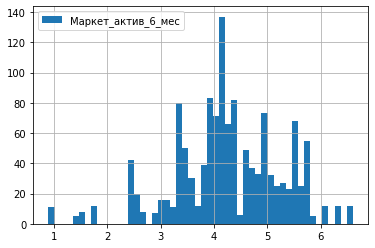

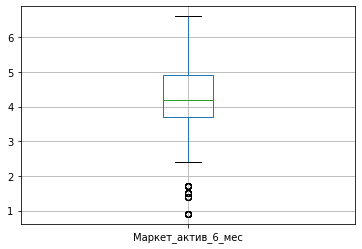

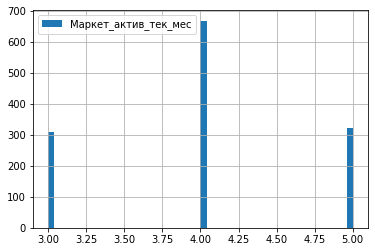

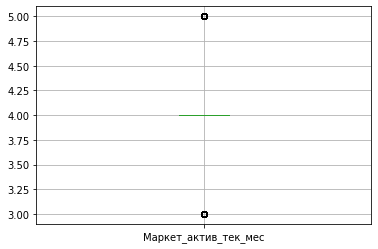

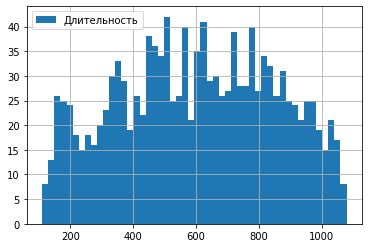

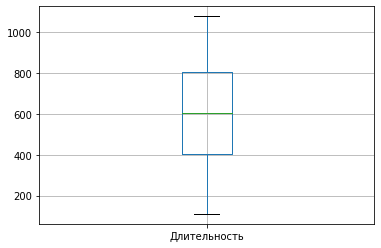

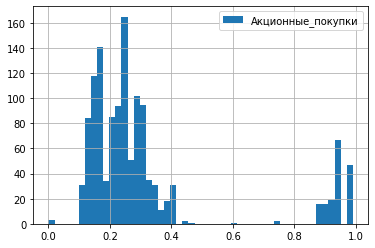

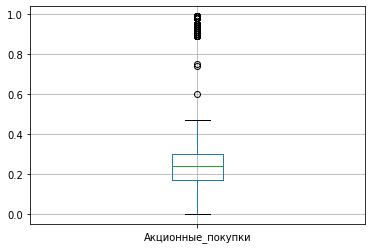

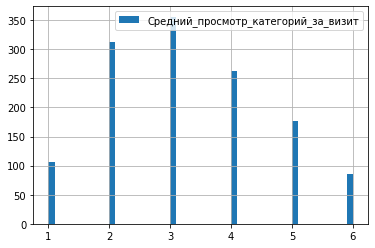

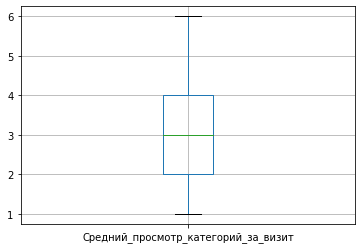

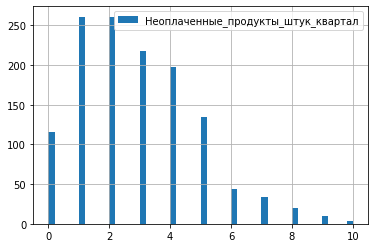

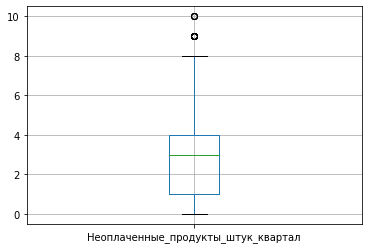

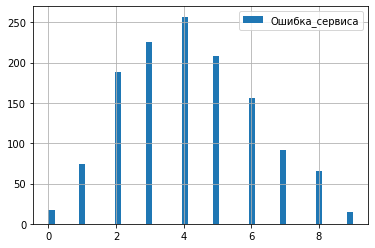

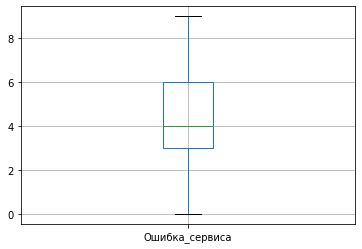

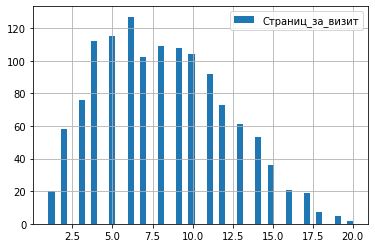

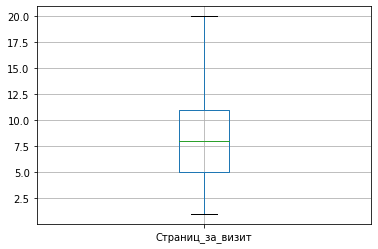

In [33]:
#диаграммы market_file
for i in market_file_col:
        market_file[i].hist(legend=True, bins=50)
        plt.show()
        market_file.boxplot(column=i)
        plt.show()

**Выводы**  
Количество рассылок, звонков, показов рекламы на клиента за 6 месяцев в размере 4 встречается чаще всего. Это совсем немного.  
В акционных покупках наблюдается два пика. Вероятно, было две акции. При этом во второй раз покупок было намного меньше.  
Чаще всего просматривают по 3 категории за визит.  
В среднем за 3 месяца у клиента лежат по 1-2 неоплаченных товара в корзине.  
4 сбоя за посещение сайта встречается чаще всего.  
Чаще всего клиенты посещают 5-6 страниц за визит.


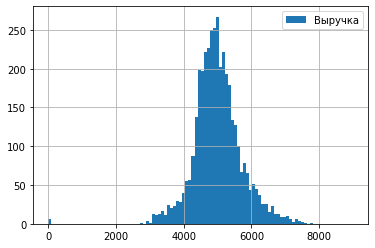

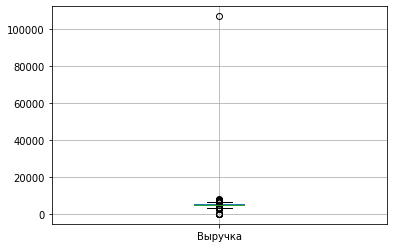

In [34]:
#диаграммы market_money
for i in market_money_col:
        market_money[i].hist(legend=True, range=(0,9000), bins=100)
        plt.show()
        market_money.boxplot(column=i)
        plt.show()

array([[<AxesSubplot:title={'center':'предыдущий_месяц'}>,
        <AxesSubplot:title={'center':'препредыдущий_месяц'}>],
       [<AxesSubplot:title={'center':'текущий_месяц'}>, <AxesSubplot:>]],
      dtype=object)

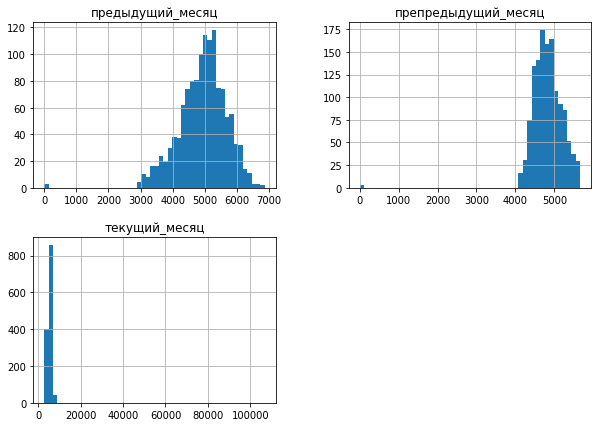

In [35]:
#дополнительно можно взглянуть на выручку в каждый период
market_money.pivot_table(index='id', columns='Период', values='Выручка').hist(figsize=(10, 7),bins=50)

In [36]:
market_money.pivot_table(index='id', columns='Период', values='Выручка').describe()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
count,1300.000000,1300.000000,1300.000000
mean,4936.920385,4825.206923,5314.960846
std,739.597997,405.979663,2939.708156
min,0.000000,0.000000,2758.700000
25%,4496.750000,4583.000000,4706.050000
50%,5005.000000,4809.000000,5179.950000
75%,5405.625000,5053.500000,5761.725000
max,6869.500000,5663.000000,106862.200000


**Вывод**  
Наблюдается незначительный выброс в 0. Видно, что средняя выручка с каждым месяцем немного увеличивается

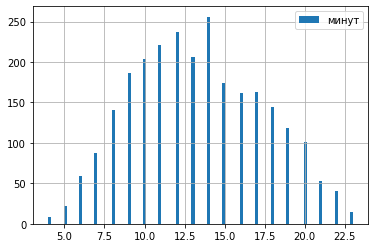

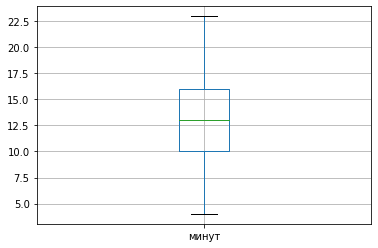

In [37]:
#диаграммы market_time
for i in market_time_col:
        market_time[i].hist(legend=True, bins=100)
        plt.show()
        market_time.boxplot(column=i)
        plt.show()

In [38]:
market_time.groupby('Период')['минут'].describe()

,count,mean,std,min,25%,50%,75%,max
Период,,,,,,,,
предыдущий_месяц,1300.0,13.467692,3.932029,5.0,11.0,13.0,17.0,23.0
текущий_месяц,1300.0,13.204615,4.220589,4.0,10.0,13.0,16.0,23.0


**Вывод**  
Время на сайте в текущем месяце немного ниже, чем в предыдущем

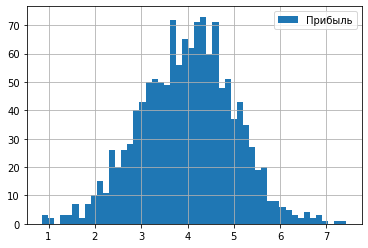

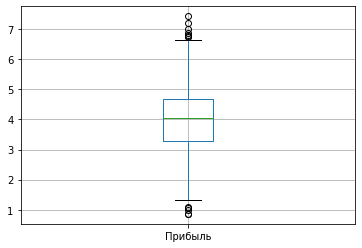

In [39]:
#диаграммы money
for i in money_col:
        money[i].hist(legend=True, bins=50)
        plt.show()
        money.boxplot(column=i)
        plt.show()

In [40]:
money['Прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

**Выводы**  
Распределение прибыли близко к нормальному, среднее значение прибыли почти 4%. Среднее и мода не сильно отличаются, значит нет аномальных выбросов.

### Категориальные признаки

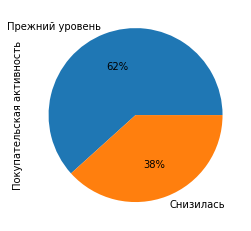

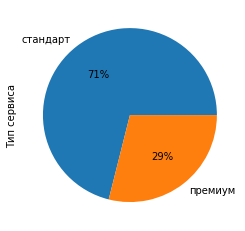

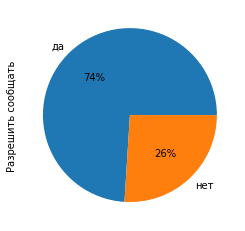

In [41]:
#диаграммы market_money
for i in market_file_cat:
    market_file[i].value_counts().plot(kind = 'pie', autopct = '%1.0f%%')
    plt.show()

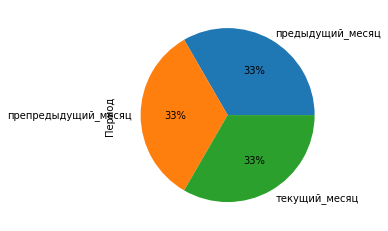

In [42]:
for i in market_money_cat:
    market_money[i].value_counts().plot(kind = 'pie', autopct = '%1.0f%%')
    plt.show()

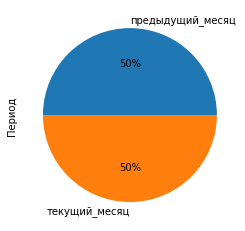

In [43]:
for i in market_time_cat:
    market_time[i].value_counts().plot(kind = 'pie', autopct = '%1.0f%%')
    plt.show()

**Выводы:**  
Диаграммы говорят о следующем: большая часть клиентов сохранила покупательскую активность; большинство пользуются стандартным сервисом; выручки за каждый из трех месяцев примерно одинаковые; время проведённое на сайте тоже не отличается.

## Объединение таблиц

Сперва необходимо провести некоторые преобразования таблиц market_money и market_time. А именно: построить новые столбцы и сформировать сводные таблицы по индексу. Для объединение необходимо, чтобы у всех датасетов было одинаковое количество строк.

### Подготовка таблиц

In [44]:
#создание новых столбцов
market_money['Выручка_за_препредыдущий_месяц'] = market_money.loc[market_money['Период']=='препредыдущий_месяц']['Выручка']
market_money['Выручка_за_предыдущий_месяц'] = market_money.loc[market_money['Период']=='предыдущий_месяц']['Выручка']
market_money['Выручка_за_текущий_месяц'] = market_money.loc[market_money['Период']=='текущий_месяц']['Выручка']

#удаление лишних столбцов и занчений NaN
market_money = market_money.drop(columns=['Период','Выручка'])
market_money.fillna(0).head()

,id,Выручка_за_препредыдущий_месяц,Выручка_за_предыдущий_месяц,Выручка_за_текущий_месяц
0,215348,0.0,0.0,0.0
1,215348,0.0,0.0,3293.1
2,215348,0.0,0.0,0.0
3,215349,4472.0,0.0,0.0
4,215349,0.0,0.0,4971.6


In [45]:
market_money_pivot = market_money.pivot_table(index='id', 
                                         values=['Выручка_за_препредыдущий_месяц','Выручка_за_предыдущий_месяц',
                                                'Выручка_за_текущий_месяц'], aggfunc='sum')
market_money_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Выручка_за_предыдущий_месяц     1300 non-null   float64
 1   Выручка_за_препредыдущий_месяц  1300 non-null   float64
 2   Выручка_за_текущий_месяц        1300 non-null   float64
dtypes: float64(3)
memory usage: 40.6 KB


In [46]:

market_time['Время_за_препредыдущий_месяц'] = market_time.loc[market_time['Период']=='препредыдущий_месяц']['минут']
market_time['Время_за_предыдущий_месяц'] = market_time.loc[market_time['Период']=='предыдущий_месяц']['минут']
market_time['Время_за_текущий_месяц'] = market_time.loc[market_time['Период']=='текущий_месяц']['минут']
market_time = market_time.drop(columns=['Период','минут'])
market_time.fillna(0).head()

,id,Время_за_препредыдущий_месяц,Время_за_предыдущий_месяц,Время_за_текущий_месяц
0,215348,0.0,0.0,14.0
1,215348,0.0,13.0,0.0
2,215349,0.0,0.0,10.0
3,215349,0.0,12.0,0.0
4,215350,0.0,0.0,13.0


In [47]:
market_time_pivot = market_time.pivot_table(index='id', 
                                         values=['Время_за_препредыдущий_месяц','Время_за_предыдущий_месяц',
                                                'Время_за_текущий_месяц'], aggfunc='sum')
market_time_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Время_за_предыдущий_месяц     1300 non-null   float64
 1   Время_за_препредыдущий_месяц  1300 non-null   float64
 2   Время_за_текущий_месяц        1300 non-null   float64
dtypes: float64(3)
memory usage: 40.6 KB


### Объединение таблиц

In [48]:
data_market = market_file.merge(market_money_pivot, on='id', how='left')
data_market = data_market.merge(market_time_pivot, on='id', how='left')

data_market.shape
data_market.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_за_предыдущий_месяц,Выручка_за_препредыдущий_месяц,Выручка_за_текущий_месяц,Время_за_предыдущий_месяц,Время_за_препредыдущий_месяц,Время_за_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5.0,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13.0,0.0,14.0
1,215349,Снизилась,премиум,да,4.4,4.0,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,0.0,10.0
2,215350,Снизилась,стандарт,нет,4.9,3.0,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,0.0,13.0
3,215351,Снизилась,стандарт,да,3.2,5.0,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,0.0,13.0
4,215352,Снизилась,стандарт,нет,5.1,3.0,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,0.0,11.0


Необходимо отобрать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Обратимся к датасету money - именно по нему можно соориентироваться по покупательской активности. Если прибыль от клиента в этой таблице = 0, то это нам не подходит. В таблице money необходимо оставить только те id, у кого прибыль больше 0. Ниже можно увидеть, что таких id нет.

In [49]:
#необходимо убрать клиентов, которые не совершали покупки ни разу за 3 месяца
data_market = data_market[(data_market['Выручка_за_предыдущий_месяц']!=0) & 
                          (data_market['Выручка_за_препредыдущий_месяц']!=0) & 
                          (data_market['Выручка_за_текущий_месяц']!=0)]
data_market.shape

(1297, 19)

**Вывод:**  
Таблицы объединены, сделаны отдельные столбцы для каждого периода, удалены клиенты с покупательской активностью менее трех месяцев.

## Корреляционный анализ data_market

In [50]:
cat_col_names =['Тип сервиса','Разрешить сообщать','Популярная_категория']
num_col_names = ['Маркет_актив_6_мес','Маркет_актив_тек_мес','Длительность',
                 'Акционные_покупки','Средний_просмотр_категорий_за_визит',
                 'Неоплаченные_продукты_штук_квартал','Ошибка_сервиса','Страниц_за_визит',
                 'Выручка_за_препредыдущий_месяц','Выручка_за_предыдущий_месяц',
                 'Выручка_за_текущий_месяц','Время_за_предыдущий_месяц',
                 'Время_за_текущий_месяц']

In [51]:
RANDOM_STATE = 42
X = data_market.drop(columns =['id','Покупательская активность'])
y = data_market['Покупательская активность']
    
#деление на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
    
ohe = OneHotEncoder(sparse=False, drop='first')
    
# обучение и преобразование категориальных признаков
X_train_ohe = ohe.fit_transform(X_train[cat_col_names])
X_test_ohe = ohe.transform(X_test[cat_col_names])
    
encoder_col_names = ohe.get_feature_names_out()
    
#масштабирование количественных признаков

scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train[num_col_names])

X_test_scaler = scaler.transform(X_test[num_col_names])
    
# создаём датафрейм из закодированных данных
# передаём названия столбцов из переменной encoder_col_names
        
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train_scaler = pd.DataFrame(X_train_scaler, columns=num_col_names)
X_test_scaler = pd.DataFrame(X_test_scaler, columns=num_col_names)
    
# обнуляем индексы строк перед объединением количественных и категориальных 
# признаков в датафрейм
X_train = X_train.reset_index()
X_test = X_test.reset_index()

# объединяем количественные и категориальные признаки 
    
X_train = pd.concat([X_train_ohe, X_train_scaler], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaler], axis=1)

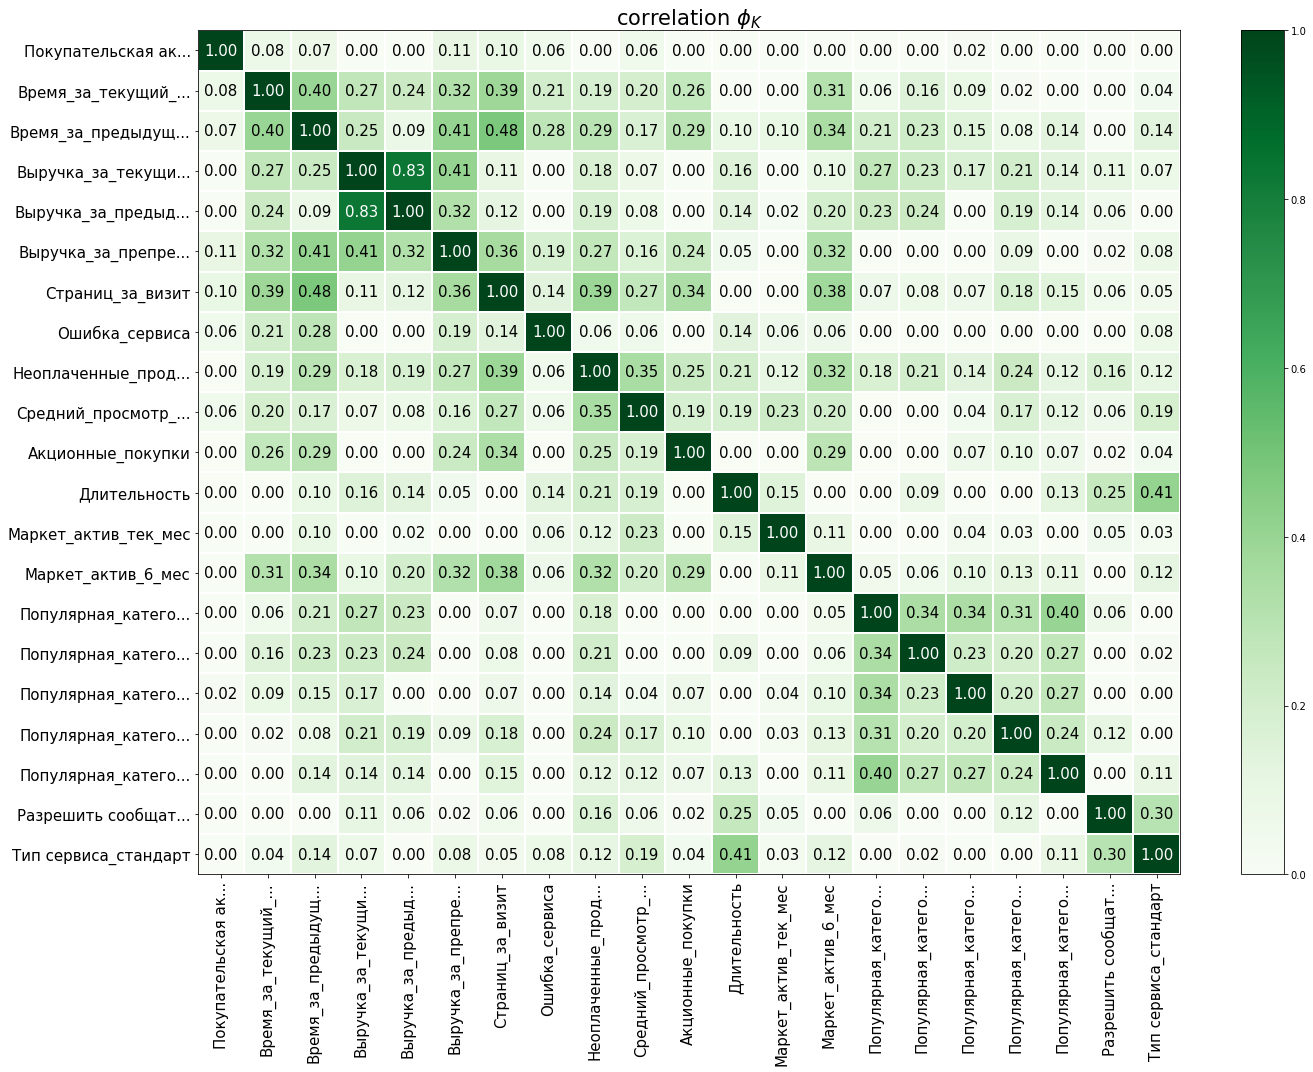

In [52]:
phik_overview = phik_matrix(X_train.join(y_train), interval_cols=num_col_names) 
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

**Вывод**  
Проанализировав матрицу, можно сказать что существует довольно значительная корреляция между столбцамив с выручкой за предыдущий и текущий месяцы. Так же можно предположить, что скорее всего была значительная корреляция между столбцами с выручкой за каждый месяц со столбцом Выручка. Но он был удален ранее, поэтому мультиколлинеарности мы уже не наблюдаем.  
с

##  Использование пайплайнов

### Пайплайн с подготовкой данных

In [53]:
RANDOM_STATE=42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    data_market.drop(['id','Покупательская активность'], axis=1),
    data_market['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data_market['Покупательская активность'])

In [54]:
# создаём списки с названиями признаков
cat_ohe_names =['Популярная_категория','Разрешить сообщать']
cat_ord_names = ['Тип сервиса']
num_col_names = ['Маркет_актив_6_мес','Маркет_актив_тек_мес','Длительность',
                 'Акционные_покупки','Средний_просмотр_категорий_за_визит',
                 'Неоплаченные_продукты_штук_квартал','Ошибка_сервиса','Страниц_за_визит',
                 'Выручка_за_препредыдущий_месяц','Выручка_за_предыдущий_месяц',
                 'Выручка_за_текущий_месяц','Время_за_предыдущий_месяц',
                 'Время_за_текущий_месяц']

In [55]:
# создаём пайплайн для подготовки признаков из списка cat_ohe_names
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
) 

In [56]:
# создаём пайплайн для подготовки признаков из списка cat_ord_names
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ])

In [57]:
#общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_ohe_names),
        ('ord', ord_pipe, cat_ord_names),
        ('num', MinMaxScaler(), num_col_names)
       
        
    ], 
    remainder='passthrough'
) 

### Моделирование

In [58]:
#финальный пайплайн
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


In [59]:
#подбор гиперпараметров
param_grid = [
      
        # словарь для модели DecisionTreeClassifier() 
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']
    },  
        # словарь для модели KNeighborsClassifier() 
    {
        'models' : [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']
    },
        # словарь для модели LogisticRegression() 
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']
    },
        # словарь для модели SCV() 
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel = 'poly', degree = 2, probability=True)],
        'models__C': range(1,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']
 
    }]

Обоснование выбора метрики roc_auc: необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.

In [60]:
rs_search = RandomizedSearchCV (
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE)
rs_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['Популярная_категория',
                                                                                'Разрешить '
                                                                                'сообщать']),
                                                                              ('ord',
                                                                               Pipeline(step...
                                        {'models': [LogisticRegression(C=4,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(degree=2, kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [61]:
print('Лучшая модель и её параметры:\n\n', rs_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', rs_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория',
                                                   'Разрешить сообщать']),
                                                 ('ord',
                                        

In [62]:
# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred = rs_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.9238886214090837


## Анализ важности признаков

### Оценка важности признаков для лучшей модели. Построение графика важности методом SHAP

Сперва сделаем предобработку данных, учитывая параметры лучшей модели

In [63]:
#закодируем заново признаки
X_train_new = data_preprocessor.fit_transform(X_train)
X_test_new = data_preprocessor.transform(X_test)
#X_train_new с полиномиальными признаками
X_train_new_df = pd.DataFrame(X_train_new, columns=data_preprocessor.get_feature_names_out())
X_train_new_df.shape

(972, 21)

In [64]:
#инициализируем лучшую модель и обучим её
final_model = LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')
final_model.fit(X_train_new, y_train)

LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')

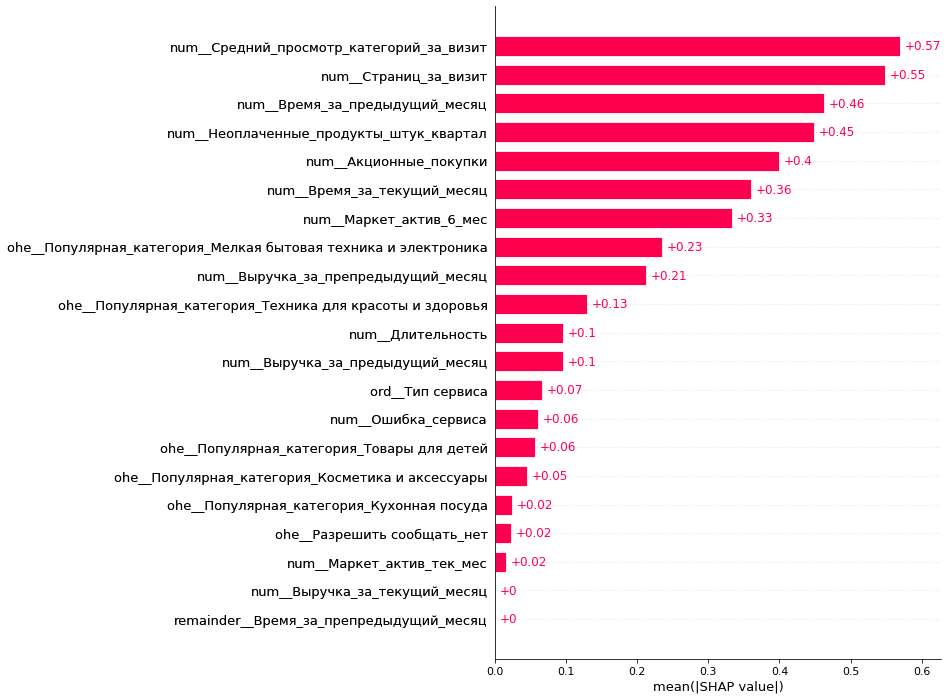

In [65]:
#оценим важность признаков с помощью метода SHAP 
explainer = shap.LinearExplainer(final_model, X_train_new)
shap_values = explainer(X_train_new_df)
#отразим общий вклад признаков в прогнозы модели с помощью диаграммы shap.plots.bar
shap.plots.bar(shap_values, max_display=21)

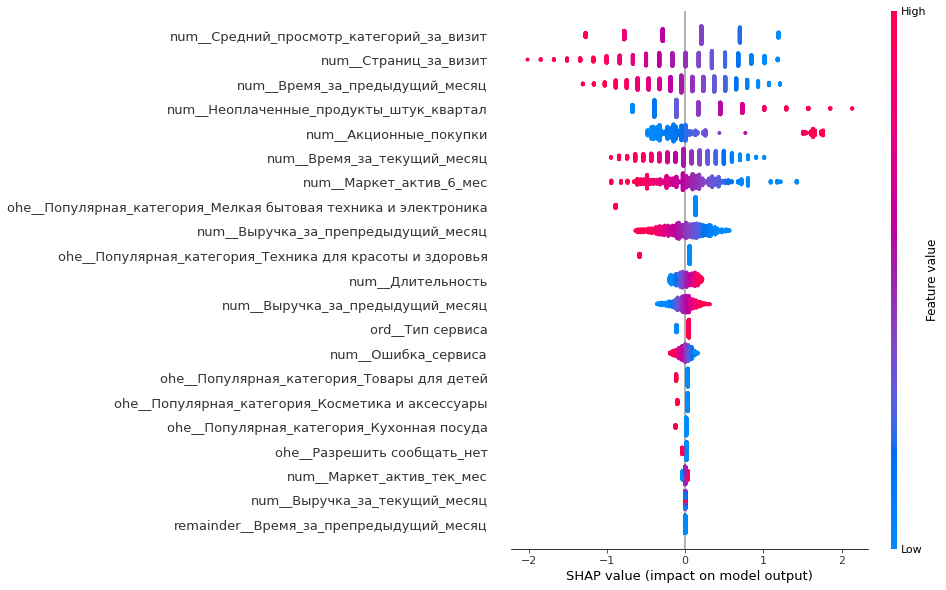

In [66]:
#визуализируем вклад признаков в каждое предсказание модели с помощью диаграммы shap.plots.beeswarm
shap.plots.beeswarm(shap_values, max_display=21)

**Вывод:** Самые высокие средние SHAP-значения имеют признаки 'Средний_просмотр_категорий_за_визит', 'Страниц_за_визит'. Эти признаки сильнее всего влияют на целевой признак - Покупательская активность. 

## Сегментация покупателей

Выберем группу покупателей с высокой вероятность снижения покупательской активности

<AxesSubplot:>

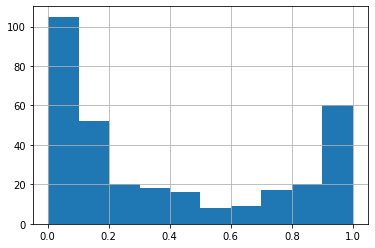

In [67]:
#создадим столбец с вероятностью снижения покупательской активности с помощью тестовой выбоки
test = y_test_pred[:,1]
X_test['вероятность_снижения_покупательской_активности']=test
X_test['вероятность_снижения_покупательской_активности'].hist()

На гистограмме видно, что есть несколько групп с высокой и низкой вероятностью снижения покупательской активности. Группа с вероятностью больше 0.9 достаточно многичесленная, стоит рассмотреть подробнее и найти решения для уменьшения этой вероятности.

Text(0.5, 0, 'Количество покупателей')

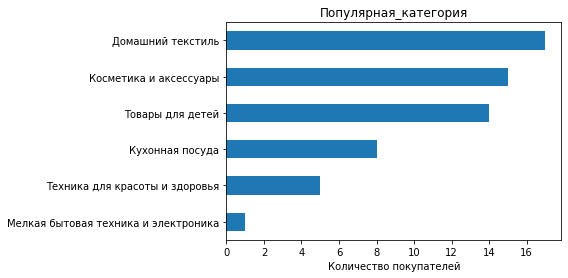

In [68]:
target_segment = X_test[X_test['вероятность_снижения_покупательской_активности']>0.9]
target_segment['Популярная_категория'].value_counts().sort_values().plot.barh()
plt.title('Популярная_категория') 
plt.xlabel('Количество покупателей')

**Вывод:** Три категории с самой высокой вероятностью снижения активности: покупатели домашнего текстиля, косметики и аксессуаров и товаров для детей.  
На анализе важности признаков мы получили два признака, больше всего влияющих на покупательскую активность:  'Средний_просмотр_категорий_за_визит', 'Страниц_за_визит'.
Для увеличения активности трех категорий, обозначенных выше, можно рекомендовать увеличить ассортимент внутри категорий и повысить просмотр страниц из этих категорий. 

## Общий вывод

**Описание задачи:** разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.  

**Исходные данные и предобработка:**  
были даны 4 датафрейма с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;  
с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;  
с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода;  
с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. 

В ходе предобработки были изменены некоторые типы данных, устранены опечатки. Датафреймы объединили и были выделены отдельные столбцы по выручке и времени на сайте для каждого периода: препредыдущий месяц, предыдущий месяц, текущий месяц. Так же были устранены пользователи, с клиентской активностью менее трех месяцев.  

**Исследовательский анализ** показал что количество рассылок, звонков, показов рекламы на клиента за 6 месяцев в размере 4 встречается чаще всего. Это меньше одного раза в месяц. В акционных покупках наблюдается два пика. Вероятно, было две акции. При этом во второй раз покупок было намного меньше. Чаще всего клиенты просматривают по 3 категории за визит. В среднем за 3 месяца у клиента лежат по 1-2 неоплаченных товара в корзине. У клиентов нередко бывает по 4 сбоя на сайте за посещение. Чаще всего клиенты посещают 5-6 страниц за визит. Средняя выручка с каждым месяцем немного увеличивается, а средняя прибыль составляет около 4%. Большинство клиентов пользуются стандартным сервисом.  

**Корреляционный анализ** показал зависимость целевого признака от выручки за препредыдущий месяц и количества просмотренных за визит страниц.

С помощью случайного поиска гиперпараметров была найдена наилучшая модель обучения в виде логистической регрессии.

Проведенный **анализ важности признаков** показал, что признаки 'Средний_просмотр_категорий_за_визит', 'Страниц_за_визит' сильнее всего влияют на покупательскую активность.

На этапе сегментации пользователей выделили три категории с самой высокой вероятностью снижения активности: покупатели домашнего текстиля, косметики и аксессуаров и товаров для детей.

Для повышения покупательской активности можно рекомендовать увеличить ассортимент внутри категорий и повысить просмотр страниц из этих категорий. 